# **Fine Tuning - CIFAR10 on ResNet50 - using TensorFlow with Keras**

In this part, we take pre-trained model **ResNet50** and using **Tranfer Learning** technique to train it on **CIFAR10** dataset.

We performs **Fine Tuning** using **TensoFlow** with **Keras** by **Python**.

ResNet50 Architecture:
![link text](https://miro.medium.com/max/1100/0*9LqUp7XyEx1QNc6A.webp)

## **1. Import Laberies, Load Dataset and Preprocesse the data**

In [ ]:
# importing tensorflow and Keras for doing ML
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.api._v2.keras as keras

from keras import layers
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.models import load_model
from keras.datasets import cifar10
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator

### **Loading our CIFAR-10 Dataset and preprocess it images**


![](https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

In [ ]:
# Download our dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Display our data shape/dimensions
print("Data Set:")
print('train samples: ', x_train.shape[0])
print('test samples: ', x_test.shape[0])
print('x_train shape:', x_train.shape)

x_train = np.array([cv2.resize(img, (224, 224)) for img in x_train])
x_test = np.array([cv2.resize(img, (224, 224)) for img in x_test])

print("\nResizing images..")
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Now we one hot encode outputs
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

np.random.seed(1000)

input_shape=(224,224,3)

# Define the labels of CIFAR-10 datasest
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Data Set:
train samples:  50000
test samples:  10000
x_train shape: (50000, 32, 32, 3)

Resizing images..
x_train shape: (50000, 224, 224, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 224, 224, 3)
y_test shape: (10000, 1)


### **Display some images from our dataset**

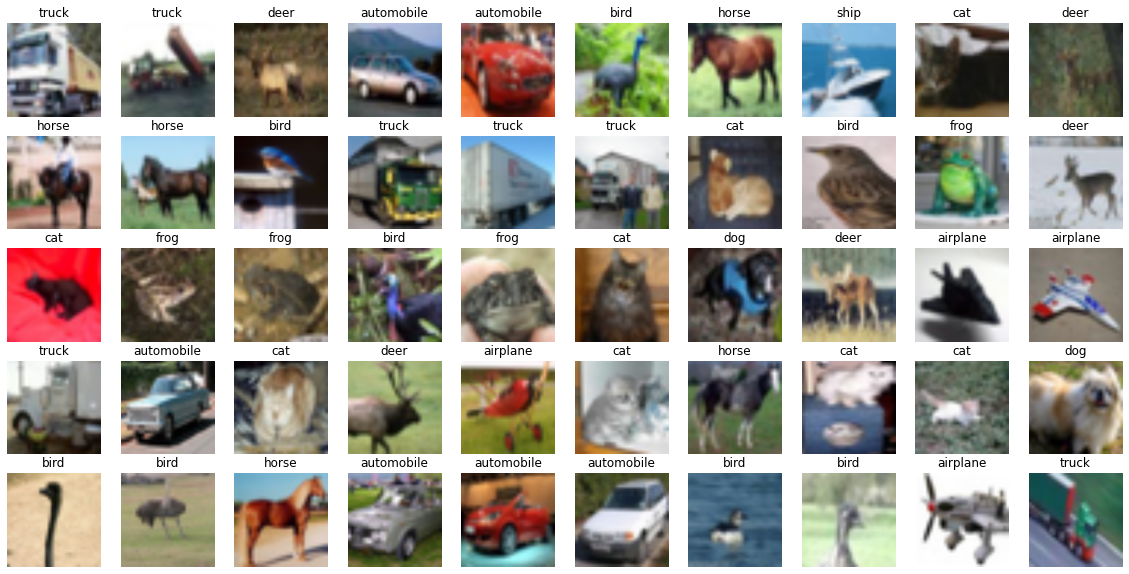

In [ ]:
# Define figure size
plt.figure(figsize=(20,10))

# Define number of images to display
num_of_images = 50


# iterate index from 1 to 51 to show the first 50 images from training dataset
for index in range(1, num_of_images +1):
  plt.subplot(5, 10, index).set_title(labels[np.argmax(y_train[index])])
  plt.axis('off')
  plt.imshow(x_train[index])


## **2. Building The Model**

#### **Load pre-trained ResNet50 Model**

In [ ]:
# Load ResNet50 model without the top and define input shape to (224 X 224 X 3)
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Print the model summary
ResNet50_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### **Freezing the base model layers**

In [ ]:
# Create ResNet50 model as type Sequential
last_layer = ResNet50_base_model.get_layer('conv5_block3_out')
last_layer_output = last_layer.output
first_layer_input = ResNet50_base_model.input
ResNet50_model_fnc = tf.keras.Model(first_layer_input, last_layer_output)

# Freezing the train layers in the model
for layer in ResNet50_model_fnc.layers:
   layer.trainable = False

# Print the model summary and type
print(type(ResNet50_model_fnc))
ResNet50_model_fnc.summary()

<class 'keras.engine.functional.Functional'>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                 

### **Build our model and fit it to our data set**

In [ ]:
# Create Sequential type model
model = Sequential()

# Add the ResNet50 base model into it
model.add(ResNet50_model_fnc)

# Build the model input
model.build(input_shape) 

# Flatten the last layer of the base model output
model.add(Flatten())

# Build the last layers on the base model and fit it to our dataset 
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, 'softmax'))

# Print the model type and summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

## **3. Training The Model**

#### Now we **unfreeze** the base model and train the entire model end-to-end with low learning rate

In [ ]:
# Make the model trainable
model.trainable = True

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
optimizer = Adam(learning_rate=1e-5)
loss_function = 'categorical_crossentropy'

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [ ]:
# Training the model
epochs = 25
batch_size = 64

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks = [es])

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
782/782 [==============================] - 103s 113ms/step - loss: 1.3719 - accuracy: 0.5839 - val_loss: 0.4733 - val_accuracy: 0.8476
Epoch 2/25
782/782 [==============================] - 86s 110ms/step - loss: 0.5431 - accuracy: 0.8254 - val_loss: 0.3345 - val_accuracy: 0.8908
Epoch 3/25
782/782 [==============================] - 86s 110ms/step - loss: 0.3498 - accuracy: 0.8878 - val_loss: 0.2671 - val_accuracy: 0.9144
Epoch 4/25
782/782 [==============================] - 86s 110ms/step - loss: 0.2362 - accuracy: 0.9246 - val_loss: 0.2405 - val_accuracy: 0.9239
Epoch 5/25
782/782 [==============================] - 86s 109ms/step - loss: 0.1582 - accuracy: 0.9502 - val_loss: 0.2339 - val_accuracy: 0.9279
Epoch 6/25
782/782 [==============================] - 86s 109ms/step - loss: 0.1078 - accuracy: 0.9665 - val_loss: 0.2324 - val_accuracy: 0.9314
Epoch 7/25
782/782 [==============================] - 86s 109ms/step - loss: 0.0716 - accuracy: 0.9791 - val_loss: 0.2331 - val_a

## **4. Reduce overfitting**


As we see, our model perfoms 98% training accuracy, wich is pritty good, but if we look closer we will notice that our validation accuracy is 93% wich is lower. Thats  means our model is overfitting. Overfitting means our model performs good on the training data set but fails to generalize on the unseen data. We can try to reduce overfitting by usuin three main ways:

1. Add more data
2. Decrease model complexity
3. Apply regularization

Lets try to reduce overfitting by using Data Augmentation techniqe.
We do it by adding one more layer wich perfoms horizontal flip and  rotation on the images in the begining.

### **Now we add a layer of data augmentation to our model and try to increase our result**

In [ ]:
import keras.api._v2.keras as keras
from tensorflow import keras
from tensorflow.keras import layers

# Adding Data agumentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#### **Visualize our Data Augmentation**

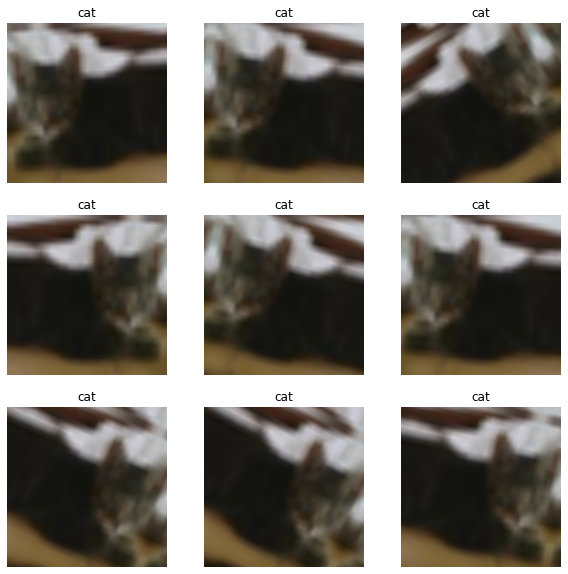

In [ ]:
image = np.expand_dims(x_train[9], axis=0)

image = tf.convert_to_tensor(image)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(image, training=True)
    augmented_image = augmented_image[0].numpy().astype("int32")
    # augmented_image = cv2.resize(augmented_image, (32, 32))
    plt.imshow(augmented_image)
    plt.title(labels[np.argmax(y_train[9])])
    plt.axis("off")

#### **Training our Model with Data Augmentation layer**

In [ ]:
input_shape = (1, 224, 224, 3)

# Create Sequential type model
model_da = Sequential()

# Add data augmentation layer into it
model_da.add(data_augmentation)

# Add the ResNet50 base model into it
model_da.add(ResNet50_model_fnc)

# Build the model input
model_da.build(input_shape) 

# Flatten the last layer of the base model output
model_da.add(Flatten())

# Build the last layers on the base model and fit it to our dataset 
model_da.add(Dense(256, activation='relu'))
model_da.add(BatchNormalization())
model_da.add(Dropout(0.5))
model_da.add(Dense(256, activation='relu'))
model_da.add(BatchNormalization())
model_da.add(Dropout(0.5))
model_da.add(Dense(num_classes, 'softmax'))

# Print the model type and summary
model_da.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (1, 224, 224, 3)          0         
                                                                 
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (1, 100352)               0         
                                                                 
 dense_3 (Dense)             (1, 256)                  25690368  
                                                                 
 batch_normalization_2 (Batc  (1, 256)                 1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (1, 256)                  0         
                                                      

In [ ]:
# Make the model trainable
model_da.trainable = True

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=1e-5)

# Compile the model
model_da.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Display the model summary
model_da.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (1, 224, 224, 3)          0         
                                                                 
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (1, 100352)               0         
                                                                 
 dense_3 (Dense)             (1, 256)                  25690368  
                                                                 
 batch_normalization_2 (Batc  (1, 256)                 1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (1, 256)                  0         
                                                      

In [ ]:
# Training the model
epochs = 25
batch_size = 64

history = model_da.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks = [es])

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model_da.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Epoch 10: early stopping
# Test loss: 0.16414378583431244
# Test accuracy: 0.9532999992370605

Epoch 1/25
782/782 [==============================] - 119s 143ms/step - loss: 0.8110 - accuracy: 0.7552 - val_loss: 0.2662 - val_accuracy: 0.9181
Epoch 2/25
782/782 [==============================] - 110s 140ms/step - loss: 0.3986 - accuracy: 0.8796 - val_loss: 0.2186 - val_accuracy: 0.9331
Epoch 3/25
782/782 [==============================] - 109s 140ms/step - loss: 0.3154 - accuracy: 0.9049 - val_loss: 0.1886 - val_accuracy: 0.9427
Epoch 4/25
782/782 [==============================] - 109s 140ms/step - loss: 0.2672 - accuracy: 0.9181 - val_loss: 0.1821 - val_accuracy: 0.9457
Epoch 5/25
782/782 [==============================] - 110s 140ms/step - loss: 0.2302 - accuracy: 0.9286 - val_loss: 0.1734 - val_accuracy: 0.9482
Epoch 6/25
782/782 [==============================] - 109s 140ms/step - loss: 0.1991 - accuracy: 0.9392 - val_loss: 0.1740 - val_accuracy: 0.9490
Epoch 7/25
782/782 [==============================] - 109s 140ms/step - loss: 0.1756 - accuracy: 0.9460 - val_loss: 0.1724 -

### **Implements Data Augmentations with Image Data Generator**

In [ ]:
input_shape = (1, 224, 224, 3)

# Create Sequential type model
model_dag = Sequential()

# Add the ResNet50 base model into it
model_dag.add(ResNet50_model_fnc)

# Build the model input
model_dag.build(input_shape) 

# Flatten the last layer of the base model output
model_dag.add(Flatten())

# Build the last layers on the base model and fit it to our dataset 
model_dag.add(Dense(256, activation='relu'))
model_dag.add(BatchNormalization())
model_dag.add(Dropout(0.5))
model_dag.add(Dense(256, activation='relu'))
model_dag.add(BatchNormalization())
model_dag.add(Dropout(0.5))
model_dag.add(Dense(num_classes, 'softmax'))

# Print the model type and summary
model_dag.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                      

In [ ]:
# Make the model trainable
model_dag.trainable = True

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=1e-5)

# Compile the model
model_dag.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Display the model summary
model_dag.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                      

In [ ]:
epochs = 25
batch_size = 64

# Define Data Generator for Augmentation
train_datagen = ImageDataGenerator( rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

# Notice we use train_datagen.flow, this takes data & label arrays, generates batches of augmented data.
history = model_dag.fit(train_datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs,
                              callbacks = [es],
                              validation_data = (x_test, y_test),
                              verbose = 1,
                              steps_per_epoch = x_train.shape[0] // batch_size)

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model_dag.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
781/781 [==============================] - 481s 605ms/step - loss: 1.5860 - accuracy: 0.5262 - val_loss: 0.5256 - val_accuracy: 0.8317
Epoch 2/25
781/781 [==============================] - 470s 602ms/step - loss: 0.7100 - accuracy: 0.7766 - val_loss: 0.3452 - val_accuracy: 0.8898
Epoch 3/25
781/781 [==============================] - 470s 602ms/step - loss: 0.4869 - accuracy: 0.8476 - val_loss: 0.2859 - val_accuracy: 0.9067
Epoch 4/25
781/781 [==============================] - 470s 602ms/step - loss: 0.3764 - accuracy: 0.8815 - val_loss: 0.2352 - val_accuracy: 0.9221
Epoch 5/25
781/781 [==============================] - 465s 596ms/step - loss: 0.3067 - accuracy: 0.9038 - val_loss: 0.2042 - val_accuracy: 0.9355
Epoch 6/25
781/781 [==============================] - 467s 598ms/step - loss: 0.2543 - accuracy: 0.9191 - val_loss: 0.1854 - val_accuracy: 0.9426
Epoch 7/25
781/781 [==============================] - 468s 599ms/step - loss: 0.2153 - accuracy: 0.9329 - val_loss: 0.1714 -

## **5. Model Performance Analysis**

In [ ]:
# Import our load_model function 
from keras.models import load_model

# We can load the built in datasets from this function
from keras.datasets import cifar10

# Load our model
model = load_model('cifar10_ResNet50_Fine_Tuning.h5')

# Loads the CIFAR dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = np.array([cv2.resize(img, (224, 224)) for img in x_train])
x_test = np.array([cv2.resize(img, (224, 224)) for img in x_test])
y_train = y_train
y_test = y_test

np.random.seed(1000)

# Define the labels of CIFAR-10 datasest
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#### **Ploting our Loss and Accuracy Charts**

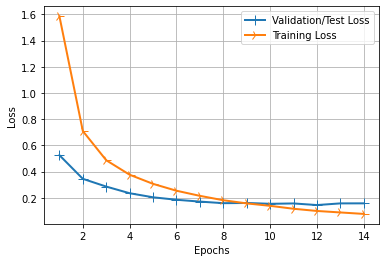

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

# Use the History object we created to get our saved performance results
history_dict = history.history

# Extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs and create an array up to that number using range()
epochs = range(1, len(loss_values) + 1)

# Plot line charts for both Validation and Training Loss
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

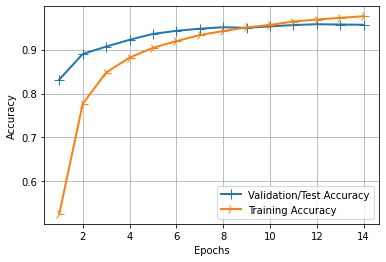

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

#### **Creating our Confusion Matrix**


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

x_test = x_test.reshape(10000, 224, 224, 3) 
y_pred = np.argmax(model.predict(x_test), axis=-1)

print(confusion_matrix(y_test, y_pred))

313/313 [==============================] - 6s 17ms/step
[[956   5   3   4   2   0   2   0  22   6]
 [  0 980   0   0   0   0   0   0   3  17]
 [ 11   0 945   7  12   5  16   2   2   0]
 [  2   0  10 873  13  80  11   6   1   4]
 [  2   0   6   4 976   2   3   7   0   0]
 [  0   0   5  35   9 941   1   9   0   0]
 [  2   0   5   9   2   3 977   1   0   1]
 [  0   0   2   4  15   9   0 970   0   0]
 [ 16   3   1   0   0   0   1   0 975   4]
 [  1  27   0   0   0   0   0   0   2 970]]


In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

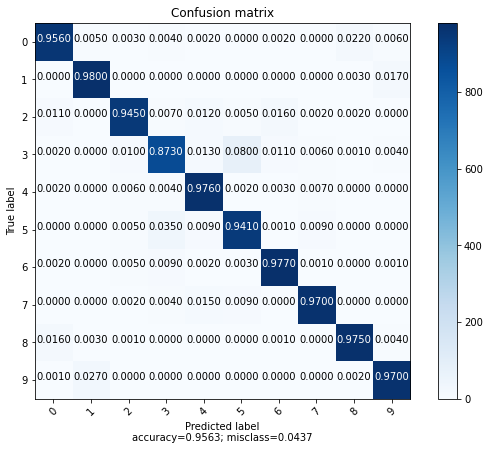

In [ ]:
target_names = list(range(0,10))
conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat, target_names)

#### **Let's look at our per-class accuracy**

In [ ]:
# Per-class accuracy
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

for (i, classAccuracy) in enumerate(class_accuracy):
    print(f'Accuracy for {labels[i]} : {classAccuracy:.3f}%')

Accuracy for airplane : 95.600%
Accuracy for automobile : 98.000%
Accuracy for bird : 94.500%
Accuracy for cat : 87.300%
Accuracy for deer : 97.600%
Accuracy for dog : 94.100%
Accuracy for frog : 97.700%
Accuracy for horse : 97.000%
Accuracy for ship : 97.500%
Accuracy for truck : 97.000%


#### **Visualizing the Images Our Model Misclassified**

In [ ]:
import numpy as np

# Reshape y_test to the y_pred shape
y_test = np.reshape(y_test, (1, 10000))

# Use numpy to create an array that stores a value of 1 when a misclassification occurs
result = np.absolute(y_test[0] - y_pred)
misclassified_indices = np.nonzero(0 < result)

print(f"Indices of misclassifed data are: \n{misclassified_indices}")
print(len(misclassified_indices[0]))

Indices of misclassifed data are: 
(array([  37,   59,   61,   68,   86,  125,  147,  164,  226,  255,  275,
        277,  287,  295,  308,  355,  378,  384,  422,  428,  456,  470,
        518,  531,  637,  641,  665,  671,  683,  689,  710,  715,  725,
        727,  728,  735,  739,  760,  770,  776,  810,  850,  870,  895,
        910,  953, 1001, 1007, 1042, 1050, 1118, 1131, 1163, 1166, 1177,
       1179, 1180, 1247, 1262, 1280, 1325, 1334, 1346, 1394, 1439, 1442,
       1495, 1496, 1506, 1521, 1536, 1538, 1587, 1644, 1684, 1727, 1732,
       1767, 1772, 1779, 1791, 1813, 1830, 1835, 1841, 1869, 1871, 1884,
       1886, 1895, 1898, 1935, 1937, 1969, 1993, 2010, 2078, 2128, 2159,
       2165, 2172, 2232, 2233, 2242, 2262, 2298, 2299, 2350, 2372, 2405,
       2455, 2473, 2495, 2511, 2515, 2530, 2532, 2581, 2590, 2592, 2633,
       2634, 2696, 2762, 2779, 2783, 2785, 2798, 2804, 2845, 2854, 2958,
       2997, 3013, 3014, 3049, 3059, 3073, 3094, 3113, 3150, 3158, 3164,
       3181, 31

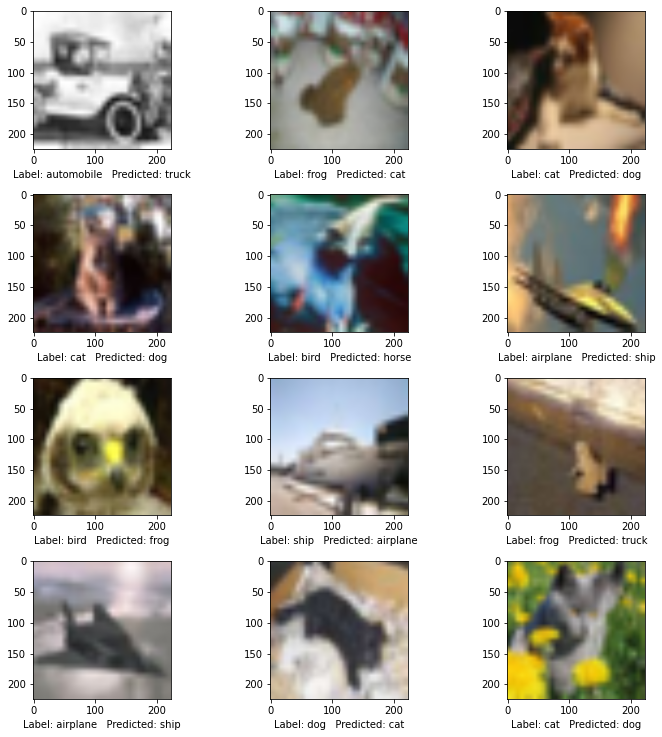

In [ ]:
i = 0
plt.figure(figsize=(10, 15))

for cel in misclassified_indices[0]:

    index = misclassified_indices[0][i]
    image = x_test[index]
    label = labels[y_test[0][index]]
    predicted = labels[y_pred[index]]
    plt.subplot(6, 3, i+1)
    plt.imshow(image)
    plt.xlabel("Label: " + label + "   Predicted: " + predicted)
    i +=1
    if i == 12:
      break

plt.tight_layout()
plt.show()

## **6. Save The Model**

In [ ]:
model_dag.save("cifar10_ResNet50_Fine_Tuning_95.h5")
print("Model Saved")

Model Saved
